# **Elasto-thermo-visco-plastic damage model of an interphase layer**

**Derivation notebook incorporating an intrinsic heat development due to cyclic shear loading on an interface  
coupled with sliding-decohesion-compression behavior**

Chudoba, R., Vořechovský, M., Aguilar, M., Baktheer, A.

This notebook explains the derivation of the interface model based on the thermodynamic 
principles using a `CAS` system. It shows how to obtain the time-stepping algorithm 
directly from the specification of the thermodynamic potentials, i.e. the Helmholtz 
free energy, threshold function and flow potential.

<div style="background-color:lightblue;text-align:center"> 
To execute the code in a cell, press [Shift+Enter]. By executing the cells one-by-one starting from top and reading the annotation of the steps between executable cells, you will be able to follow the abstract thermodynamic derivation leading to an executable simulation code.
</div>

The abstract implementation of the return mapping algorithm for general 
damage-plasticity modes. The basic ingredients of of a thermodynamically based model
are introduced as

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of thermodynamic streses $\boldsymbol{\mathcal{S}}$
 - Helmholtz free energy $\psi(\boldsymbol{\mathcal{E}})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

Based on the symbolic formulation using the `sympy` package, the time-stepping algorithm
is generated automatically by requiring the consistency condition to hold for each 
prescribed load increment.

**Scientific computing in Python**: The Jupyter notebook is executed in a `Python environment` that can be automatically installed using the `conda` package manager. The list of required package is specified [here](../environment.yml). In the subsequent derivation and demonstration, following three packages are used:
 1. Computer algebra is implemented using the `sympy` package ([https://www.sympy.org](https://www.sympy.org)).
 2. The derived expressions are transformed to an executable Python code in terms of `numpy` - a multi-dimensional array package ([https://www.numpy.org](https://www.numpy.org)). 
 3. Plotting of simulation results is done using the `matplotlib` package ([https://www.matplotlib.org](https://www.matplotlib.org)). 

In [1]:
%matplotlib widget 
import sympy as sp # CAS used for symbolic derivations 
sp.init_printing()
import matplotlib.pyplot as plt # plotting package
from matplotlib import cm # color maps for plotting
from sympy.utilities.codegen import codegen # code generation package
import numpy as np # array based numerical package 
np.seterr(divide='ignore', invalid='ignore') # suppress warnings on division by zero
from cymbol import Cymbol, ccode # Symbol class 
from sympy import Heaviside

**From expressions to executable code**: The transformation of the algebraic expressions, vectors and matrices into an executable code is done in two ways. For direct quantitative demonstration of the derived algorithm, the executable `Python` code is obtained using the `numpy.lambdify` method. To show how to transform the code into executable `C` code, at the end of the notebook, the `sympy` subpackage `codegen` is applied. To enable both pretty printing of symbolic expressions and `C` language naming of the variables, the standard `sympy` class called `sympy.Symbol` is overloaded by an own subclass named `Cymbol` that makes it possible to provide the attribute named `codename` for the `C` code generator autonomosly. 

**Heaviside and Dirac delta functions**: Starting with `sympy` 1.9, Heaviside function can be correctly handled
in the `lambdified` code. However, `DiracDelta` function is still not available in the printer. Therefore, a dummy
`get_dirac_delta` is added here as a workaround.

In [2]:
H = Heaviside
def get_dirac_delta(x):
    return 0
numpy_dirac =[{'DiracDelta': get_dirac_delta }, 'numpy']

&nbsp;<font color='blue'>
**Naming conventions:**
 - Python language convention using lowercase letters separated by underscores is used for the variable and function names.
 - Variables with trailing underscore (e.g. `f_`, or `Sig_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `Sig` have no underscore at the end and have a name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `Cymbol(r'\tau^{\pi}')` use `latex` syntax to introduce Greek symbols, super and subindexes. This makes the pretty printing of expression possible.

# **1 Symbolic derivation of thermodynamic potentials**

**Include the notebook with the derived threshold function**

The derivation of the continuous and smooth threshold function combining the elliptical capps in the tension and compression with the linear part in the tangential direction is derived in a separate notebook. 
To prepare the symbols for all material parameters, we include the derivation here using the `%run` command. The `%%capture` magic command is used to supress any printing and plotting done in the executed notebook.  
[threshold_function.ipynb](threshold_function.ipynb)

In [3]:
%%capture
%run threshold_function.ipynb

## Extension steps to include rate dependency and viscoplastic regularization

 - add viscosity as a material parameter $\eta$
 - modify the coupling parameter of normal and tangential damage from $\eta$ to $\zeta$
 - introduce a symbolic expression for relaxation time in the form
   $t^\mathrm{relax}_\mathrm{N} = \frac{\zeta_\mathrm{N}}{E_\mathrm{N}}$, 
   $t^\mathrm{relax}_{\mathrm{T}(.)} = \frac{\zeta_\mathrm{T}}{E_\mathrm{T} + K_\mathrm{T} + \gamma}_\mathrm{T}$

## **1.1 Free energy potential, state variables and thermodynamic forces**

### Material parameters

In [4]:
E_T = Cymbol(r'E_{\mathrm{T}}', codename='E_T_', real=True, nonnegative=True)
gamma_T = Cymbol(r'\gamma_{\mathrm{T}}', codename='gamma_T_', real=True)
K_T = Cymbol(r'K_{\mathrm{T}}', codename='K_T_', real=True)
S_T = Cymbol(r'S_{\mathrm{T}}', codename='S_T_', real=True, nonnegative=True)
r_T = Cymbol(r'r_{\mathrm{T}}', codename='r_T_', real=True, nonnegative=True)
c_T = Cymbol(r'c_{\mathrm{T}}', codename='c_T_', real=True, nonnegative=True)

E_N = Cymbol(r'E_{\mathrm{N}}', codename='E_N_', real=True, nonnegative=True)
gamma_N = Cymbol(r'\gamma_{\mathrm{N}}', codename='gamma_N_', real=True)
S_N = Cymbol(r'S_{\mathrm{N}}', codename='S_N_', real=True, nonnegative=True)
r_N = Cymbol(r'r_{\mathrm{N}}', codename='r_N_', real=True, nonnegative=True)
c_N = Cymbol(r'c_{\mathrm{N}}', codename='c_N_', real=True, nonnegative=True)

eta_N = Cymbol(r'\eta_{\mathrm{N}}', codename='eta_N_', real=True, nonnegative=True)
eta_T = Cymbol(r'\eta_{\mathrm{T}}', codename='eta_T_', real=True, nonnegative=True)
zeta = Cymbol('zeta', codename='zeta_', real=True, nonnegative=True)
chi = Cymbol('chi', codename='chi_', real=True, nonnegative=True)

# temperature 
S_E_bar = Cymbol(r'\bar{S}_{\mathrm{E}}', codename='S_E_bar_', real=True, nonnegative=True)
T_bar = Cymbol(r'\bar{T}', codename='T_bar_', real=True, nonnegative=True)
C_v = Cymbol(r'C_{\mathrm{v}}', codename='C_v_', real=True, nonnegative=True)
T_0 = Cymbol(r'T_0', codename='T_0_', real=True, nonnegative=True)

In [5]:
sp_vars = (E_T, gamma_T, K_T, S_T, c_T, f_s, E_N, gamma_N, S_N, c_N, m, f_t, f_c, f_c0, 
           r_N, r_T, eta_N, eta_T, zeta, S_E_bar, T_bar, C_v, T_0)
sp_vars

### State variables

In [6]:
u_Tx = Cymbol(r'u_{\mathrm{T}x}', codename='u_Tx_', real=True)
u_Ty = Cymbol(r',u_{\mathrm{T}y}', codename='u_Ty_', real=True)
u_p_Tx = Cymbol(r'u^{\mathrm{p}}_{\mathrm{T}x}', codename='u_p_Tx_', real=True)
u_p_Ty = Cymbol(r'u^{\mathrm{p}}_{\mathrm{T}y}', codename='u_p_Ty_', real=True)
omega_T = Cymbol(r'\omega_{\mathrm{T}}', codename='omega_T_', real=True, nonnegative=True)
alpha_Tx = Cymbol(r'\alpha_{\mathrm{T}x}', codename='alpha_Tx_', real=True)
alpha_Ty = Cymbol(r'\alpha_{\mathrm{T}y}', codename='alpha_Ty_', real=True)
z_T = Cymbol(r'z_\mathrm{T}', codename='z_T_', real=True)
u_N = Cymbol(r'u_\mathrm{N}', codename='u_N_', real=True)
omega_N = Cymbol(r'\omega_\mathrm{N}', codename='omega_N_', real=True, nonnegative=True)
u_p_N = Cymbol(r'u^{\mathrm{p}}_\mathrm{N}', codename='u_p_N_', real=True)
T = Cymbol(r'T', codename='T_', real=True)

In [7]:
Eps = sp.Matrix([u_p_Tx, u_p_Ty, u_p_N, z_T, alpha_Tx, alpha_Ty, omega_T, omega_N, T])
Eps.T

### Helmholtz free energy

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

In [8]:
sigma_Tx = Cymbol(r'\sigma_{\mathrm{T}x}', codename='sigma_Tx_', real=True)
sigma_Ty = Cymbol(r'\sigma_{\mathrm{T}y}', codename='sigma_Ty_', real=True)
sigma_p_Tx = Cymbol(r'\sigma^\mathrm{p}_{\mathrm{T}x}', codename='sigma_p_Tx_', real=True)
sigma_p_Ty = Cymbol(r'\sigma^\mathrm{p}_{\mathrm{T}y}', codename='sigma_p_Ty_', real=True)
X_Tx = Cymbol(r'X_{\mathrm{T}x}', codename='X_Tx_', real=True)
X_Ty = Cymbol(r'X_{\mathrm{T}x}', codename='X_Ty_', real=True)
Z_T = Cymbol(r'Z_\mathrm{T}', codename='Z_T_', real=True, nonnegative=True)
Y_T = Cymbol(r'Y_\mathrm{T}', codename='Y_T_', real=True, nonnegative=True)
sigma_N = Cymbol(r'\sigma_\mathrm{N}', codename='sigma_N_', real=True)
sigma_p_N = Cymbol(r'\sigma^{\mathrm{p}}_\mathrm{N}', codename='sigma_p_N_', real=True)
Y_N = Cymbol(r'Y_\mathrm{N}', codename='Y_N_', real=True, nonnegative=True)
S_E = Cymbol(r'S_\mathrm{E}', codename='S_E_', real=True, nonnegative=True)

In [9]:
rho_psi_g1_T_ = C_v * T**2 / (2 * T_0)

In [10]:
rho_psi_T_ = sp.Rational(1, 2) * ( 
    (1-omega_T)*E_T*(u_Tx-u_p_Tx)**2 + 
    (1-omega_T)*E_T*(u_Ty-u_p_Ty)**2 + 
    K_T * z_T**2 + 
    gamma_T * alpha_Tx**2 +
    gamma_T * alpha_Ty**2
)

rho_psi_N_ = sp.Rational(1, 2) * (
    (1 - H(sigma_p_N) * omega_N) * E_N * (u_N - u_p_N)**2
)

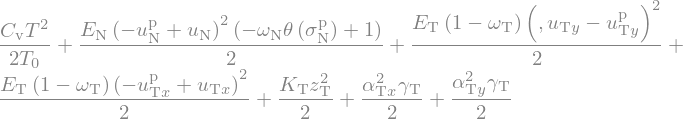

In [11]:
rho_psi_ = rho_psi_T_ + rho_psi_N_ + rho_psi_g1_T_
rho_psi_

### Thermodynamic forces

In [12]:
Sig = sp.Matrix([sigma_p_Tx, sigma_p_Ty, sigma_p_N, Z_T, X_Tx, X_Ty, Y_T, Y_N, S_E])
Sig.T

The introduce the thermodynamic forces we have to differentiate Hemholtz free energy
with respect to the kinematic state variables
\begin{align}
\frac{\partial \rho \psi }{\partial \boldsymbol{\mathcal{E}}}
\end{align}

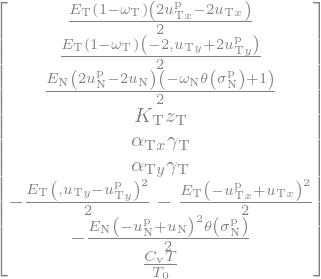

In [13]:
d_rho_psi_ = sp.Matrix([rho_psi_.diff(eps) for eps in Eps])
d_rho_psi_

To obtain consistent signs of the Helmholtz derivatives we define a sign switch operator so that all generalized forces are defined as positive for the respective conjugate state variable $\boldsymbol{\Upsilon}$. 

In [14]:
Sig_signs = sp.diag(-1, -1, -1, 1, 1, 1, -1, -1, 1)

The constitutive laws between generalized force and kinematic variables then read
\begin{align}
\boldsymbol{\mathcal{S}} = \boldsymbol{\Upsilon}\frac{\rho \psi}{\partial\boldsymbol{\mathcal{E}}} 
\end{align}

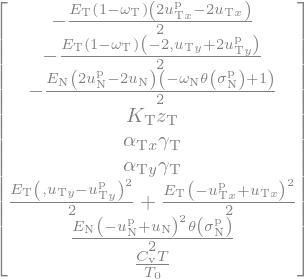

In [15]:
Sig_ = Sig_signs * d_rho_psi_
Sig_

**Executable code for** $\boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

Generate the executable code in `Python` and `C` languages.

In [16]:
get_Sig = sp.lambdify( 
    (u_Tx, u_Ty, u_N, Sig, Eps) + sp_vars + ('**kw',), Sig_.T, numpy_dirac
)
get_Sig_C = ccode('get_Sig',Sig_,'SLIDE3_4')

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\mathcal{S}}$ with respect to the kinematic variables $\boldsymbol{\mathcal{E}}$ 
\begin{align}
\frac{\partial \boldsymbol{S}}{\partial \boldsymbol{E}}
\end{align}

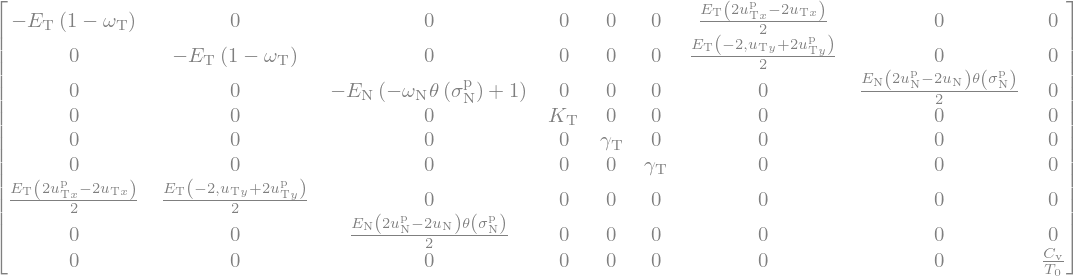

In [17]:
dSig_dEps_ = sp.Matrix([
    Sig_.T.diff(eps) for eps in Eps 
]).T
dSig_dEps_

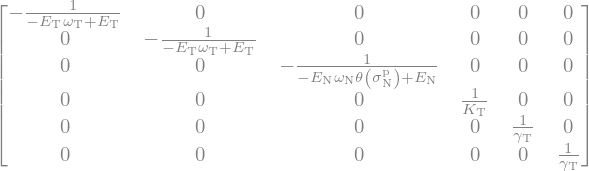

In [18]:
dEps_dSig_ = dSig_dEps_[:6,:6].inv()
dEps_dSig_

**Executable Python code generation** $\displaystyle \frac{\partial }{\partial \boldsymbol{\mathcal{E}}}  \boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [19]:
get_dSig_dEps = sp.lambdify(
    (u_Tx, u_Ty, u_N, Sig, Eps) + sp_vars + ('**kw',), dSig_dEps_, numpy_dirac
)
get_dSig_dEps_C = ccode('get_dSig_dEps', dSig_dEps_, 'SLIDE3_4')

In [20]:
get_dEps_dSig = sp.lambdify(
    (u_Tx, u_Ty, u_N, Sig, Eps) + sp_vars + ('**kw',), dEps_dSig_, numpy_dirac
)
get_dEps_dSig_C = ccode('get_dSig_dEps', dEps_dSig_, 'SLIDE3_4')

## **1.2 Threshold function**

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

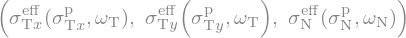

In [21]:
sigma_eff_Tx = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{T}x}')(sigma_p_Tx, omega_T)
sigma_eff_Ty = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{T}y}')(sigma_p_Ty, omega_T)
sigma_eff_N = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{N}}')(sigma_p_N, omega_N)
q_Tx = sp.Function(r'q_Tx')(sigma_eff_Tx,X_Tx)
q_Ty = sp.Function(r'q_Ty')(sigma_eff_Ty,X_Ty)
q_N = sp.Function(r'q_N')(sigma_eff_N)
sigma_eff_Tx, sigma_eff_Ty, sigma_eff_N

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

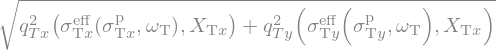

In [22]:
norm_q_T = sp.sqrt(q_Tx*q_Tx + q_Ty*q_Ty)
norm_q_T

Let us now introduce the back stress $X$ by defining the substitution for $Q = \tau^\mathrm{eff} - X$

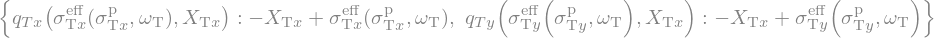

In [23]:
subs_q_T = {q_Tx: (sigma_eff_Tx - X_Tx), q_Ty: (sigma_eff_Ty - X_Ty)}
subs_q_T

In [24]:
subs_q_N = {q_N: sigma_eff_N}
subs_q_N

Further substitution rule introduces the effective stress as a function of damage as

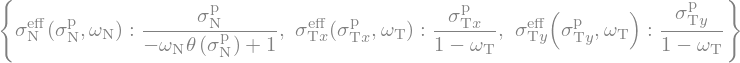

In [25]:
subs_sigma_eff = {sigma_eff_Tx: sigma_p_Tx / (1-omega_T),
                  sigma_eff_Ty: sigma_p_Ty / (1-omega_T),
                  sigma_eff_N: sigma_p_N / (1-H(sigma_p_N)*omega_N)
                 }
subs_sigma_eff

After substitutions the yield function reads

**Smooth yield function**

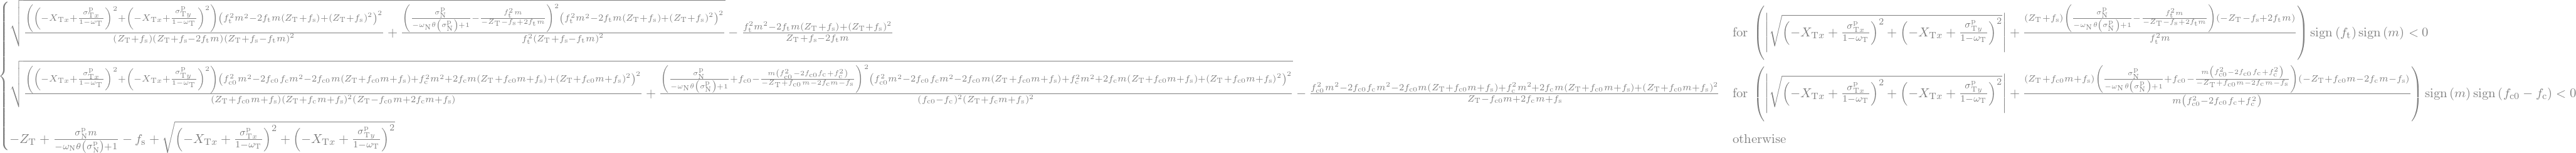

In [26]:
f_ = (f_solved_
      .subs({x: q_N, y: norm_q_T})
      .subs(subs_q_T)
      .subs(subs_q_N)
      .subs(subs_sigma_eff)
      .subs(f_s, (f_s+Z_T))
     )
f_

**Executable code generation** $f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$

Note that this is a function of both the forces and kinematic state variables

In [27]:
get_f = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), f_, numpy_dirac
)
get_f_C = ccode('get_f', f_, 'SLIDE3_4')

The derivative of $f$ required for time-stepping $\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}$ is obtained as

In [28]:
df_dSig_ = f_.diff(Sig)
# df_dSig_.T

**Executable code generation** $\displaystyle \frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [29]:
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), df_dSig_, numpy_dirac
)
get_df_dSig_C = ccode('get_df_dSig', df_dSig_, 'SLIDE1_3')

Due to the direct dependency of $f$ on $\boldsymbol{\mathcal{E}}$ also the term $\displaystyle\frac{\partial^\mathrm{dir} f}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}$ must be provided for numerical evaluation of derivatives

In [30]:
ddf_dEps_ = f_.diff(Eps)
#ddf_dEps_.T

**Executable Python code generation** $\displaystyle\frac{\partial }{\partial \boldsymbol{\mathcal{E}}} f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [31]:
get_ddf_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), ddf_dEps_, numpy_dirac
)
get_ddf_dEps_C = ccode('get_df_dEps', ddf_dEps_, 'SLIDE1_3')

In [32]:
material_params = dict(
    E_T_=1, gamma_T_=0.2, K_T_=0.1, S_T_=0.6, c_T_=1, f_s_=1, gamma_N_=2,
    E_N_=1, S_N_=0.6, c_N_=1, m_=0.2, f_t_=1, f_c_=20, f_c0_=10, zeta_=0, 
    eta_N_ = 1, eta_T_ = 1, chi_ = 0, r_N_=1, r_T_=1, S_E_bar_=1, T_bar_=1, C_v_=1, T_0_= 10
)
sig_p_range, tau_p_range = np.mgrid[-22:3:500j, -5:5:500j]

In [33]:
Eps_f = np.zeros((len(Eps),)+sig_p_range.shape,dtype=np.float_)
Sig_f = np.zeros((len(Eps),)+sig_p_range.shape,dtype=np.float_)
#Sig_f[1] = sig_p_range
Sig_f[2] = sig_p_range
Sig_f[0] = tau_p_range
f_f = get_f(Eps_f, Sig_f, **material_params)

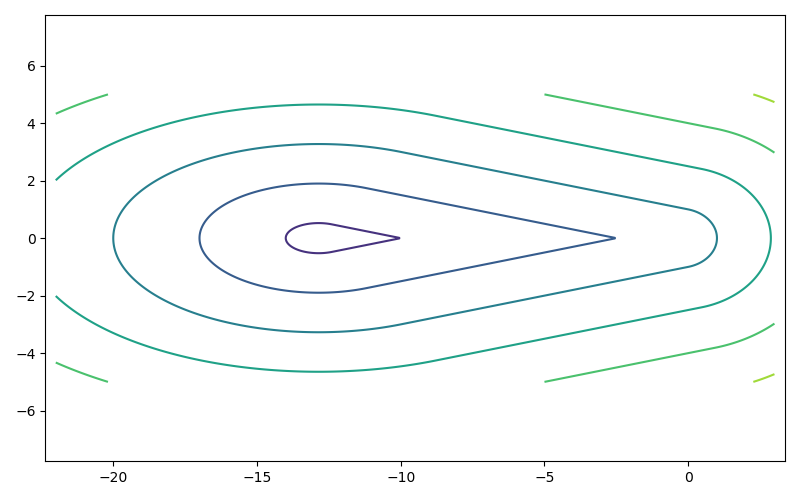

In [34]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
ax = fig.add_subplot(1, 1, 1) # , projection='3d')
ax.contour(sig_p_range, tau_p_range, f_f);
ax.axis('equal');

## **1.3 Flow potential**
For non-associative flow rule let us define an extension to be added to the threshold function 

In [35]:
phi_ext_g2_T_ = (1 + T_bar * sp.sqrt(T))
phi_ext_g3_T_ = S_E / S_E_bar

In [36]:
S_NT = sp.sqrt(S_N*S_T)
c_NT = sp.sqrt(c_N*c_T)
r_NT = sp.sqrt(r_N*r_T)
omega_NT = 1 - sp.sqrt((1-omega_N)*(1-omega_T))
phi_N = (1 - omega_N)**c_N * S_N / (r_N+1) * (Y_N / S_N)**(r_N+1)
phi_T = (1 - omega_T)**c_T * S_T / (r_T+1) * (Y_T / S_T)**(r_T+1) * phi_ext_g2_T_  
phi_NT = (1 - omega_NT)**c_NT * S_NT / (r_NT+1) * ((Y_N + Y_T)/(S_NT))**(r_NT+1)

In [37]:
phi_ext_ = ((1 - zeta)*(phi_N + phi_T) + zeta*phi_NT) - phi_ext_g3_T_ 

The flow potential $\varphi(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$ reads

In [38]:
phi_ = f_ + phi_ext_ 

and the corresponding directions of flow given as a product of the sign operator $\Upsilon$ and of the derivatives with respect to state variables 
$\boldsymbol{\Upsilon} \, \partial_{\boldsymbol{\mathcal{S}}} \varphi$
This renders following flow direction vector
\begin{align}
\boldsymbol{\Phi} = - \Upsilon \frac{\partial \varphi}{\partial \boldsymbol{\mathcal{S}}} 
\end{align}

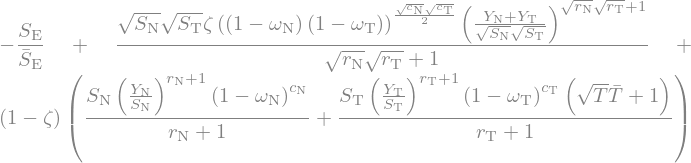

In [39]:
phi_ext_

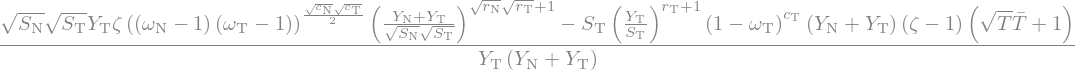

In [40]:

Phi_ = -Sig_signs * (f_.diff(Sig) + sp.simplify(phi_ext_.diff(Sig)))
Phi_[6]

**Executable code generation** $\boldsymbol{\Phi}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [41]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), Phi_, numpy_dirac
)
get_Phi_C = ccode('get_Phi', Phi_, 'SLIDE1_3')

## 1.4 Relaxation time

introduce a symbolic expression for relaxation time in the form
   $t^\mathrm{relax}_\mathrm{N} = \frac{\eta_\mathrm{N}}{E_\mathrm{N}}$, 
   $t^\mathrm{relax}_{\mathrm{T}(.)} = \frac{\eta_\mathrm{T}}{E_\mathrm{T} + K_\mathrm{T} + \gamma}_\mathrm{T}$

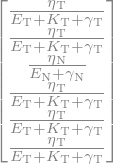

In [42]:
t_relax_N_ = eta_N / (E_N + gamma_N)
t_relax_T_ = eta_T / (E_T + K_T + gamma_T)
t_relax_ = sp.Matrix([
                    t_relax_T_,
                    t_relax_T_,
                    t_relax_N_,
                    t_relax_T_,
                    t_relax_T_,
                    t_relax_T_,
                    ] 
               )

t_relax_

In [43]:
get_t_relax = sp.lambdify(
    sp_vars + ('**kw',), t_relax_.T
)

In [44]:
get_t_relax(**material_params)[0]

array([0.76923077, 0.76923077, 0.33333333, 0.76923077, 0.76923077,
       0.76923077])

# **2 Time integration scheme**

## Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
\dot{f}(\boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}(\lambda)}), \boldsymbol{\mathcal{E}(\lambda)} ) &= 0 \end{align}
In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. 
$f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
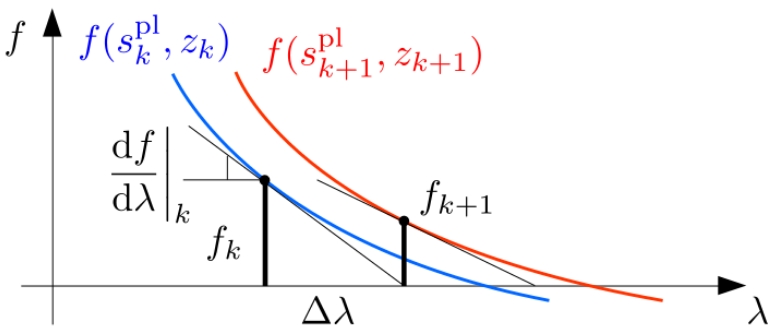
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $\boldsymbol{\mathcal{E}}_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

## State update
In every iteration step the state variables $\boldsymbol{\mathcal{E}}$ must be updated using the discrete evolution equations, i.e. 
\begin{align}
\boldsymbol{\mathcal{E}}_{k+1} &= 
\boldsymbol{\mathcal{E}}_k + \lambda_{k+1} 
\boldsymbol{\Phi}_k
\end{align}
Which is used in the calculation of the threshold function in the next step. Note that $\boldsymbol{\Phi}_k$ is evaluated in the state $k$ and not $k+1$.

To reach an admissible state let us linearize the threshold function at an interim state $k$ as
\begin{align}
f_{k+1} = 
f_k 
 +
\left.
\frac
{\partial f}
{\partial \lambda}
\right|_k
\Delta \lambda
\end{align}

## Predictor
\begin{align}
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&=
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k =
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\boldsymbol{\Phi}_k \\
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
\left. \frac{\partial f}{ \partial \boldsymbol{\mathcal{S}}}\right|_{k}
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
+
\left. \frac{\partial^{\mathrm{dir}} f}{ \partial^{\mathrm{dir}} \boldsymbol{\mathcal{E}}}\right|_{k}
\end{align}

**Remark 1:** The derivative $\partial^\mathrm{dir}$ denotes the direct derivative with respect to $\boldsymbol{\mathcal{E}}$

**Remark 2:** Note that $\displaystyle \frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}$ in equation $\eqref{eq:df_dlambda}$ can be obtained from the evolution equations $\eqref{eq:discrete_evolution}$
\begin{align}
\boldsymbol{\mathcal{E}}_k = \boldsymbol{\mathcal{E}}_n + \lambda \, \boldsymbol{\Phi}_k\; \implies
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k = 
\boldsymbol{\Phi}_k
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
\Delta \lambda
= - f^{(k)}\\
& \lambda_{k+1} = \lambda_{k} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}_{k+1} = \boldsymbol{\mathcal{E}}_{k} + 
 \lambda_{k} \, 
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
 \\
&k = k + 1
\end{align}

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(s, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}}  \boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_df_dEps</td>
<td>get_df_dEps_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} \varphi(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_Phi</td>
<td>get_Phi_C</td>
</tr>
</table>

**Threshold and its derivatives:** To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\partial_\lambda f$ into a single procedure. The iteration loop can be constructed in such a way that the predictor for the next step is calculated along with the residuum. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, can be even reused in the next time step.  

In [45]:
def get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw):
    Sig_k = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)[0]
    dSig_dEps_k = get_dSig_dEps(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)
    f_k = np.array([get_f(Eps_k, Sig_k, **kw)])
    if f_k < -1e-1: # elastic step
        return f_k, np.array([[0]]), Sig_k
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, **kw)
    ddf_dEps_k = get_ddf_dEps(Eps_k, Sig_k, **kw)
    df_dEps_k = np.einsum(
        'ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    dEps_dlambda_k = Phi_k
    df_dlambda = np.einsum(
        'ki,kj->ij', df_dEps_k, dEps_dlambda_k)
    df_k = df_dlambda
    return f_k, df_k, Sig_k

In [46]:
Eps_0 = np.zeros((len(Eps),), dtype=np.float_)
material_params = dict(
    E_T_=1, gamma_T_=1, K_T_=1, S_T_=1, c_T_=1, f_s_=1, 
    E_N_=1, gamma_N_=1, S_N_=0.5, c_N_=1, m_=0.05, f_t_=1, f_c_=-20, f_c0_=-10, 
    r_N_=2, r_T_=2, zeta_=0., eta_N_=1, eta_T_=11, S_E_bar_=1e+3, T_bar_=0, T_0_=1, C_v_=1
)
Sig_k = get_Sig(1.1, 0, 0, Eps_0, Eps_0, **material_params)

In [47]:
get_f_df(1.1, 0, 0, Eps_0, Eps_0, **material_params)

(array([0.1]),
 array([[-4.0025]]),
 array([ 1.1  , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.605,  0.   ,
         0.   ]))

**Evolution equations:** The update of state variables for an updated $\lambda_k$ is performed using this procedure.

In [48]:
def get_Eps_k1(u_Tx_n1, u_Ty_n1, u_N_n1, Eps_n, lam_k, Sig_n, Eps_k, **kw):
    Sig_k = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)[0]
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    Eps_k1 = Eps_n + lam_k * Phi_k[:,0]
    return Eps_k1

## Viscoplastic regularization



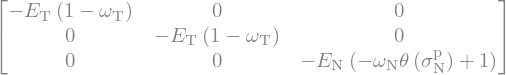

In [49]:
dSig_dEps_[:3,:3]

**Return mapping iteration:** This function represents a user subroutine in a finite element code or in a lattice model. The input is $s_{n+1}$ and the state variables representing the state in the previous solved step $\boldsymbol{\mathcal{E}}_n$. The procedure returns the stresses and state variables of $\boldsymbol{\mathcal{S}}_{n+1}$ and $\boldsymbol{\mathcal{E}}_{n+1}$

In [50]:
def get_state_n1(u_n, du_n1, dt, Sig_n, Eps_n, k_max, **kw):
    u_n1 = u_n + du_n1
    u_Tx_n1, u_Ty_n1, u_N_n1 = u_n1
    
    relax_t = get_t_relax(**kw)[0]
    n_vk = len(relax_t)
    dt_tau = dt / relax_t
    inv_1_dt_tau = 1 / (np.ones_like(dt_tau) + dt_tau)

    Eps_k = np.copy(Eps_n)
    Sig_k = np.copy(Sig_n)
    lam_k = 0
    f_k, df_k, Sig_k = get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw)
    f_k_norm = np.linalg.norm(f_k)
    f_k_trial = f_k[0]
    k = 0
    while k < k_max:
        if f_k_trial < 0 or f_k_norm < 1e-4:
            break
        delta_lambda = np.linalg.solve(df_k, -f_k)
        lam_k += delta_lambda
        Eps_k = get_Eps_k1(u_Tx_n1, u_Ty_n1, u_N_n1, Eps_n, lam_k, Sig_k, Eps_k, **kw)
        f_k, df_k, Sig_k = get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw)
        f_k_norm = np.linalg.norm(f_k)
        k += 1
    else:
        raise ValueError('no convergence')    
    # viscoplastic regularization
    if f_k_trial > 0:
        ### Perzyna type model - exploiting that \gamma = f / eta corresponds to \lambda above ???
        gamma_vk = lam_k * np.ones_like(Eps_k)
        gamma_vk[:n_vk] *= (dt_tau * inv_1_dt_tau) 
        Eps_vk = get_Eps_k1(u_Tx_n1, u_Ty_n1, u_N_n1, Eps_n, gamma_vk, Sig_n, Eps_n, **kw)
        Sig_vk = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_vk, **kw)[0]
        return Eps_vk, Sig_vk, k
    else:
        return Eps_k, Sig_k, k

### Stress integration
Backup code from using the backward Euler scheme for stress rate  
```
dSig_dEps_k = -get_dSig_dEps(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw) 
Sig_overshoot = Sig_n[:3] + np.einsum('ij,j->i', dSig_dEps_k[:3, :3], du_n1) 
Sig_k[:3] = np.einsum('i,i->i', inv_1_dt_tau[:3], Sig_overshoot + np.einsum('i,i->i', dt_tau[:3], Sig_k[:3]))
Eps_k[:3] = u_n1 - np.einsum('ij,j->i', np.linalg.inv(dSig_dEps_k[:3,:3]), Sig_k[:3])
Eps_k[3:6] = np.einsum('i,i->i', inv_1_dt_tau[3:6],
                    Eps_n[3:6] + np.einsum('i,i->i', dt_tau[3:6], Eps_k[3:6]))
Sig_k[3:6] = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw)[0][3:6]
```

$$
\bar{\sigma} =  \sigma_n + E \Delta u
$$
$$
\sigma_k = \frac{\bar{\sigma} + \Delta \tau \sigma_\infty}{1 + \Delta \tau} 
$$
$$
u^\mathrm{vp}_{n+1} = u_{n+1} - E^{-1} \sigma_k 
$$

In [51]:
Eps_0 = np.zeros((len(Eps),), dtype=np.float_)
material_params = dict(
    E_T_=1, gamma_T_=0, K_T_=0, S_T_=5, c_T_=1, r_T_=1.0, f_s_=1, 
    E_N_=1, gamma_N_=0, S_N_=5, c_N_=1, m_=0.1, f_t_=1, f_c_=20, f_c0_=10, r_N_=1, zeta_=0, chi_=1,
    eta_N_=1, eta_T_=1, zeta=0, S_E_bar_=1e+1, T_bar_=0, T_0_=10, C_v_=1
)
Eps_1, Sig_1, k = get_state_n1(np.array([0, 0, 0]), 
                               np.array([1.01, 0, 0]),
                               0.02, Eps_0, Eps_0, 50, **material_params) 
Eps_1, Sig_1, k

(array([1.94137061e-04, 0.00000000e+00, 1.94137061e-05, 1.94137061e-04,
        1.94137061e-04, 1.94137061e-04, 1.01000000e-03, 0.00000000e+00,
        9.90099010e-04]),
 array([ 1.00878596e+00, -0.00000000e+00, -1.94137061e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.09853940e-01,  0.00000000e+00,
         9.90099010e-05]),
 1)

In [52]:
Eps_0 = np.zeros((len(Eps),), dtype=np.float_)
material_params = dict(
    E_T_=50, gamma_T_=1, K_T_=1, S_T_=1e-4, c_T_=1.2, r_T_=1.0, f_s_=1, 
    E_N_=10, gamma_N_=1, S_N_=0.5, c_N_=1, m_=0.0, f_t_=1, f_c_=20, f_c0_=10, r_N_=1, zeta_=0, chi_=1,
    eta_N_=1, eta_T_=1, zeta=0, S_E_bar_=1e+1, T_bar_=0, T_0_=10, C_v_=1
)
Eps_1, Sig_1, k = get_state_n1(np.array([0, 0, 0]), 
                               np.array([0.0201, 0, 0]),
                               0.02, Eps_0, Eps_0, 50, **material_params) 
Eps_1, Sig_1, k

(array([4.80947096e-05, 0.00000000e+00, 0.00000000e+00, 4.80947096e-05,
        4.80947096e-05, 4.80947096e-05, 9.52853774e-03, 0.00000000e+00,
        9.43396226e-06]),
 array([ 9.93041998e-01, -0.00000000e+00, -0.00000000e+00,  4.80947096e-05,
         4.80947096e-05,  4.80947096e-05,  1.00519726e-02,  0.00000000e+00,
         9.43396226e-07]),
 1)

**Loop over the time increments** for a single material point. This loop emulates the  finite-element spatial integration or a lattice-assembly algorithm.  

In [53]:
def get_response(u_ta, t_t, k_max=20, **kw):
    du_ta = np.diff(u_ta, axis=0)
    dt_t = np.diff(t_t, axis=0)
    Eps_n1 = np.zeros((len(Eps),), dtype=np.float_)
    Sig_n1 = np.zeros_like(Eps_n1)
    Sig_record = []
    Eps_record = []
    iter_record = []
    Sig_record.append(Sig_n1)
    Eps_record.append(Eps_n1)
    iter_record.append(0)
    for n, dt in enumerate(dt_t):
        try:
            Eps_n1, Sig_n1, k = get_state_n1(u_ta[n], du_ta[n], dt, 
                                             Sig_n1, Eps_n1, k_max, **kw)
        except ValueError:
            break
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
        iter_record.append(k)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    n_t = len(Eps_arr)
    return t_t[:n_t], u_ta[:n_t], Eps_arr, Sig_arr, iter_arr

# Auxiliary methods

Plotting functions for the verification studies below

## Load functions

### Step load function

This code defines a symbolic step function `fn_s_t` using the Sympy Python library. Symbols (`s_1`, `t`, and `t_1`) are first defined, which represent slip, time, and a specific time point respectively.

The `Piecewise` function is then used to define `fn_s_t`, which is a step function of the input time `t`. This function behaves as follows:
- If `t` (the time) is less than `t_1` (a specific time point), the function output is a straight line with the slope `s_1 / t_1`. This part represents the linear increasing phase of slip, the slope `s_1 / t_1` is the rate at which slip increases per unit time.
- If `t` (the time) is equal to or greater than `t_1`, the function output is a constant value `s_1`. This part represents the constant phase of slip after the loading reaches its peak value `s_1`.

Then, `sp.lambdify` is used to convert the symbolic function `fn_s_t` into a lambda function `get_step_loading` that can be used with numerical computation. The lambda function takes inputs of time `t`, maximum slip `s_1` and specific point of time `t_1`.

Finally, `fn_s_t` is printed out.

In general, this block of code is handy for modelling situations where a value increases linearly over time until a specific point, before staying constant.

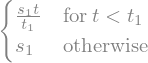

In [54]:
s_1 = sp.Symbol('s_1')
t_1 = sp.Symbol('t_1')
t = sp.Symbol('t')
fn_s_t = sp.Piecewise((t * s_1/t_1, t < t_1),(s_1, True)
)
get_step_loading = sp.lambdify((t, s_1, t_1), fn_s_t)
fn_s_t

### Cyclic loading function 

`get_cyclic_load` is a function that simulates a loading history for a cyclic load. The function accepts the maximum slip `max_s`, total simulating time `max_t`, the number of loading cycles `n_cycles`, and the number of increments `n_incr`.

In the function:

1. `np.tile(np.array([-1, 1]), n_cycles)` generates an array that alternates between -1 and 1 for `n_cycles` times. This represents the loading and unloading actions.
2. It then multiplies this array by `np.linspace(0, max_s, 2 * n_cycles)`, which simply creates an array of `2 * n_cycles` evenly-spaced values from 0 to `max_s`. This construct results in a loading history (`s_arr`) that progressively increases in absolute magnitude each cycle, from 0 to `max_s`.
3. Subsequently, `s_arr` is interpolated over a new set of time points. `np.linspace(0, max_t, n_incr * len(s_arr))` creates a list of evenly spaced time points over the total time with more time intervals. The interpolation refines the loading history `s_arr` to higher resolution.

The function also generates a time array (`t_arr`) with the same length as the interpolated `s_arr`. This array represents the simulation time points.

Finally, the function returns the loading history (`s_arr`) and the time array (`t_arr`), which could be used for analysis or simulation.

In [55]:
def get_cyclic_load(max_s, max_t, n_cycles, n_incr):
    # Generating loading history
    s_arr = np.tile(np.array([-1, 1]), n_cycles) * np.linspace(0, max_s, 2 * n_cycles)
    s_arr = np.interp(np.linspace(0, max_t, n_incr * len(s_arr)), np.linspace(0, max_t, len(s_arr)), s_arr)

    # time array as input
    t_arr = np.linspace(0, max_t, len(s_arr))
    return s_arr, t_arr

### Plotting response

The function `plot_response` is used for visualizing the simulation results. This function accepts four arguments: `param_name`, `s_arr` (array of slip), `t_arr` (array of companion timestamps), and `response_values` (dictionary containing responses).

Four subplots are generated using this function:
1. **Loading scenario**: This plot displays how slip changes with time for different values of the parameter specified by `param_name`. This information is overlaid with the viscoplastic stress (`tau_vp`) change over time.
2. **Stress-Slip relation**: This plot illustrates how viscoplastic stress (`tau_vp`) changes with slip for different parameter values.
3. **Evolution of viscoplastic slip**: This plot displays how viscoplastic slip (`s_vp`) evolves with total slip for different parameter values.
4. **Damage evolution**: This shows how the scalar damage variable (`w`) evolves with slip over time for different parameter values.

Each subplot includes a legend depicting the parameter name and its corresponding value, and zero lines for easy reference.

In [56]:
def plot_response(param_name, response_values):
    fig, ((ax1,  ax2), (ax3,  ax4)) = plt.subplots(2,2, tight_layout=True, figsize=(7,7))
    fig.canvas.header_visible = False
    ax1_twin = ax1.twinx()

    for (param, rv), color in zip(response_values.items(), ['black', 'red', 'green']):
        t_t, u_ta, Eps_t, Sig_t, iter_t = rv
        u_p_Tx_t, u_p_Ty_t, u_p_N_t, z_T_t, alpha_Tx_t, alpha_Ty_t, omega_T_t, omega_N_t, T_t = Eps_t.T
        sig_Tx_t, sig_Ty_t, sig_N_t, Z_T_t, X_Tx_t, X_Ty_t, Y_T_t, Y_N_t, S_E_t = Sig_t.T
        ax1.plot(t_t, u_ta[:, 0], color=color, linewidth=1, label="{} = {}".format(param_name, param))  # Loading scenario
        ax1_twin.plot(t_t, sig_Tx_t, linestyle='dashed', color=color, linewidth=1)
        ax2.plot(u_ta[:,0], sig_Tx_t, color=color, linewidth=1, label="{} = {}".format(param_name, param))    # Stress-slip relation
        ax3.plot(t_t, T_t, color=color, linewidth=1, label="{} = {}".format(param_name, param))      # Evolution of temp
        ax4.plot(u_ta[:, 0], omega_T_t, color=color, linewidth=1, label="{} = {}".format(param_name, param))         # Damage evolution

    ax1.axhline(y=0, color='k', linewidth=1, alpha=0.5)
    ax1.axvline(x=0, color='k', linewidth=1, alpha=0.5)
    ax1.set_title('loading scenario')
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('slip [mm]')
    ax1.legend()

    ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
    ax2.axvline(x=0, color='k', linewidth=1, alpha=0.5)
    ax2.set_title('stress-slip')
    ax2.set_xlabel('slip [mm]')
    ax2.set_ylabel('stress [MPa]')
    ax2.legend()

    ax3.axhline(y=0, color='k', linewidth=1, alpha=0.5)
    ax3.axvline(x=0, color='k', linewidth=1, alpha=0.5)
    ax3.set_title('evolution of temperature')
    ax3.set_xlabel('time [sec]')
    ax3.set_ylabel('temperature [$^{\circ}$C]')
    ax3.legend()

    ax4.axhline(y=0, color='k', linewidth=1, alpha=0.5)
    ax4.axvline(x=0, color='k', linewidth=1, alpha=0.5)
    ax4.set_title('damage evolution')
    ax4.set_xlabel('slip [mm]')
    ax4.set_ylabel('damage [-]')
    ax4.legend()

# Verfification studies

In [57]:
material_params = dict(
    E_T_=100, gamma_T_=0, K_T_=0, S_T_=1e+1, c_T_=2, f_s_=1, 
    E_N_=100, gamma_N_=0, S_N_=1e+1, c_N_=2, m_=0.0, f_t_=1, 
    f_c_=20, f_c0_=10, r_N_=1, r_T_=1, eta_N_=100, eta_T_=100, zeta_=0, 
    S_E_bar_=1e+3, T_bar_=0, T_0_=1, C_v_=1
)

## Relaxation test

Reproduce the analytical solution of step loading with the decay of stress towards the time-independent solution

In [58]:
t_max, n_t = 6, 100
t_t = np.linspace(0, t_max, n_t+1)
u_Tx_t = get_step_loading(t_t, s_1=0.12, t_1=1)
u_ta = np.zeros((len(u_Tx_t), 3))
u_ta[:, 0] = u_Tx_t

In [59]:
results = get_response(
    u_ta, t_t, k_max=50, **material_params
)
t_t_1, u_ta_1, Eps_t_1, Sig_t_1, iter_t_1 = results
len(t_t_1)

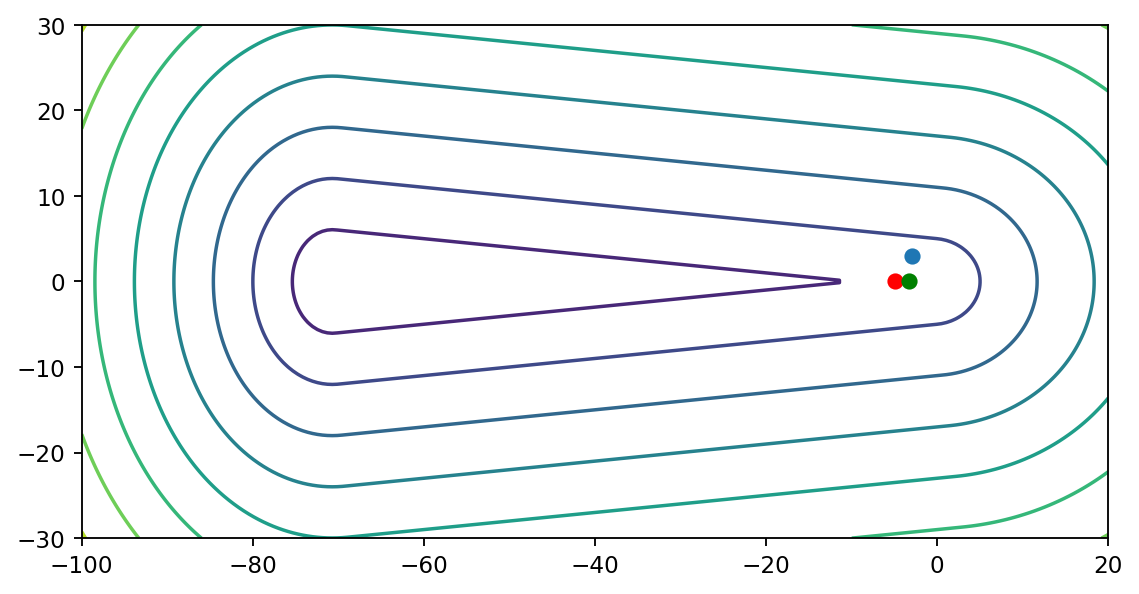

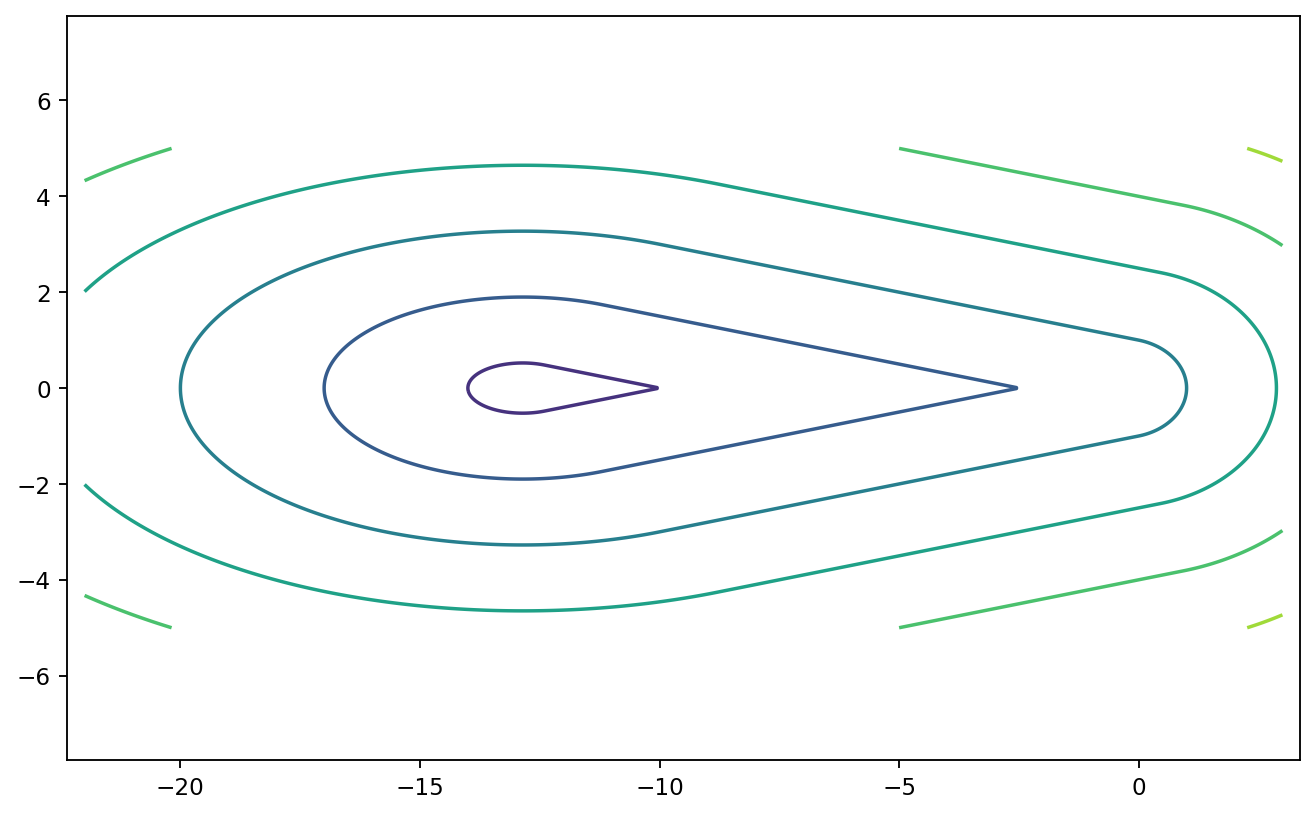

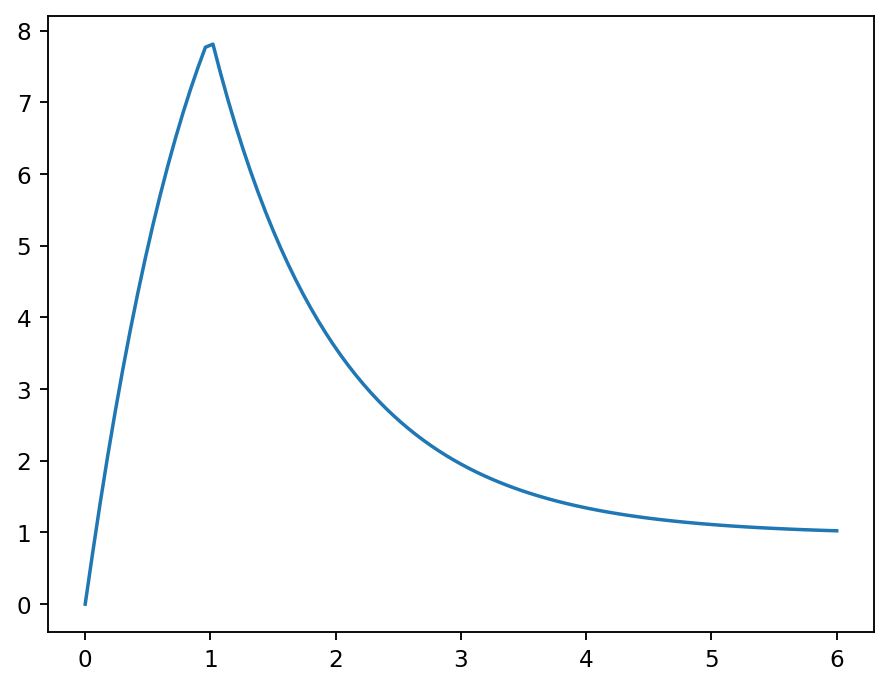

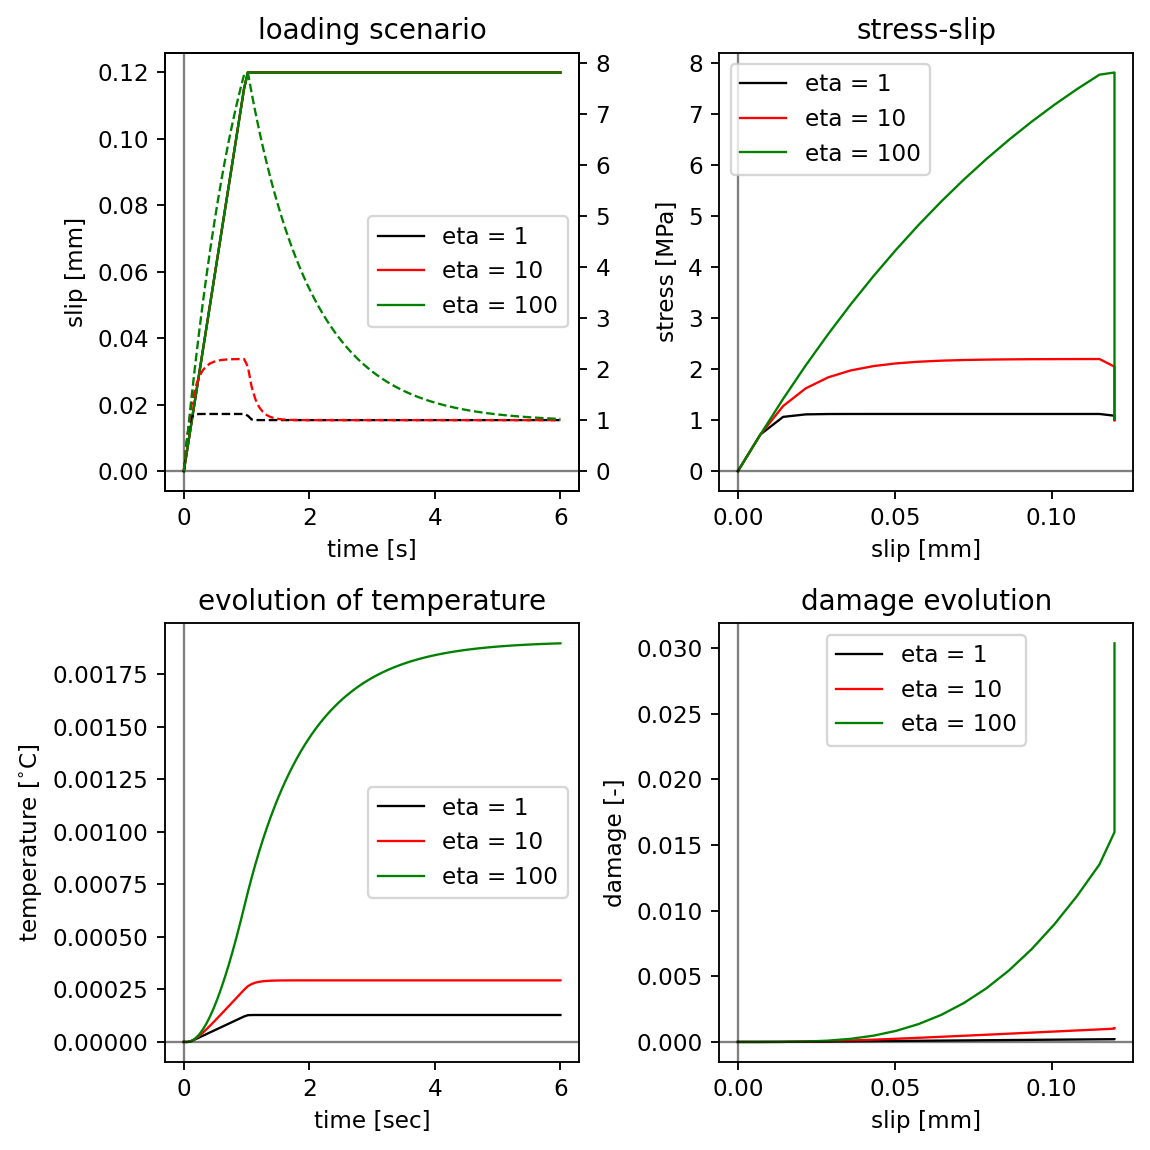

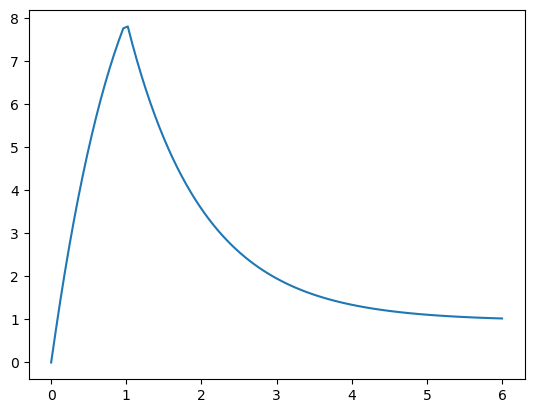

In [64]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
fig.canvas.header_visible = False
ax.plot(t_t_1, Sig_t_1[:, 0])

In [61]:
import copy
mp = copy.deepcopy(material_params)
response_values = {}
for eta_val in [1, 10, 100]:
    mp['eta_T_'] = eta_val
    response_values[eta_val] = get_response(
        u_ta, t_t, k_max=50, **mp
    )

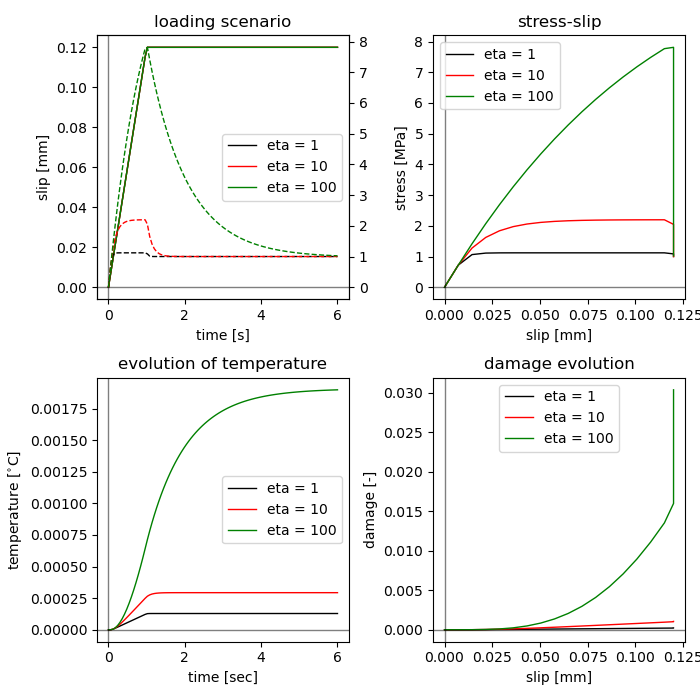

In [62]:
plot_response('eta', response_values)

## Cyclic loading test

Test the effect of viscosity for a cyclic loading with increasing amplitude

### Parametric study of viscosity parameter $\eta$

In [ ]:
u_Tx_t, t_t = get_cyclic_load(
    n_cycles = 3, max_s = 50, max_t = 10, n_incr = 100
)
u_ta = np.zeros((len(u_Tx_t), 3))
u_ta[:, 0] = u_Tx_t

In [ ]:
mp = copy.deepcopy(material_params)
mp['c_N_']=1
mp['c_T_']=1
mp['S_E_bar_']=1e+3
mp['S_N_']=1e+5
mp['S_T_']=1e+5

In [ ]:
response_values = {}
for eta_val in 0.1, 2, 10:
    mp['eta_T_'] = eta_val
    response_values[eta_val] = get_response(
        u_ta, t_t, k_max=50, **mp
    )

In [ ]:
plot_response(r'$eta$', response_values)

### Parametric study of loading rate influence on temperature evolution

In [ ]:
mp = copy.deepcopy(material_params)
mp['c_N_']=1
mp['c_T_']=1
mp['S_E_bar_']=1e+2
mp['S_N_']=1e+5
mp['S_T_']=1e+5
mp['eta_']=10

In [ ]:

response_values = {}
for dot_s in 0.05, 0.1, 1:
    max_s = 10
    u_Tx_t, t_t = get_cyclic_load( n_cycles=15, max_s=max_s, 
                                  max_t=max_s/dot_s, n_incr = 100)
    u_ta = np.zeros((len(u_Tx_t), 3))
    u_ta[:, 0] = u_Tx_t
    response_values[dot_s] = get_response(u_ta, t_t, **mp)
    
plot_response(r'$\dot{s}$', response_values)

### Parametric study of the parameter T_bar (controling the influence od temperature on damage evolution)

In [ ]:
mp = copy.deepcopy(material_params)
mp['c_N_']=1
mp['c_T_']=1
mp['S_E_bar_']=1e+2
mp['S_N_']=1e+5
mp['S_T_']=1e+5
mp['eta_']=10

In [ ]:
max_s = 10
dot_s=1
u_Tx_t, t_t = get_cyclic_load( n_cycles=15, max_s=max_s, 
                                max_t=max_s/dot_s, n_incr = 100)
u_ta = np.zeros((len(u_Tx_t), 3))
u_ta[:, 0] = u_Tx_t
response_values = {}
for T_bar_val in 0, 1 ,10:
    mp['T_bar_'] = T_bar_val
    response_values[T_bar_val] = get_response(u_ta, t_t, **mp)
    
plot_response(r'$\bar{T}$', response_values)